# DAZLS MODEL
## Domain Adaptation for Zero-Shot Learning in Sequence

**DAZLS** is the new energy splitting method which is going to be used in openSTEF.

It trains one splitting model which can be used for every prediction job.

As input it uses data from multiple substations with known components and it outputs the prediction of solar and wind power for unkown target substations.

The model contains 3-steps which are deployed in sequence:
1. Domain model (any data-driven model can be used)
2. Adaptation model (any data-driven model can be used)
3. Physical Correction model (it is specific to this task, but can be adapted)

For validation, the approach Leave-one-out is being used.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import glob
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, normalize
from sklearn.linear_model import Lasso, MultiTaskLassoCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.decomposition import KernelPCA, PCA
import random
from sklearn.utils import shuffle
from scipy.linalg import fractional_matrix_power
from sklearn.covariance import LedoitWolf, OAS
from sklearn.base import BaseEstimator

# Seed, path, etc,
random.seed(999)
np.random.seed(999)

path = os.path.dirname(os.path.abspath("prep_data"))
folder = ['\\prep_data\\']
combined_data = []
station_name = []

# Read prepared data
for file_name in glob.glob(path + folder[0] + '*.csv'):
    x = pd.read_csv(file_name, low_memory=False, parse_dates=["datetime"])
    x["datetime"] = pd.to_datetime(x["datetime"])
    x = x.set_index('datetime')
    x.columns=[x.lower() for x in x.columns]
    combined_data.append(x)
    sn = os.path.basename(file_name)
    station_name.append(sn[:len(sn) - 4])


# DAZLS algorithm
class DAZLS(BaseEstimator):
    def __init__(self):
        self.__name__ = "DAZLS"
        self.xscaler = None
        self.x2scaler = None
        self.yscaler = None
        self.domain_model = None
        self.adaptation_model = None
        self.mini = None
        self.maxi = None
        self.on_off = None
        self.target_substation_pred_data = None
        self.y_test = None

    def fit(self, data, xindex, x2index, yindex, n, domain_model_clf, adaptation_model_clf, n_delay, cc):
        x_index = list(set(np.arange(0, nn)) - set([n]))
        y_index = n
        on_off = np.asarray(combined_data[n].iloc[:, [n_delay * 3 + 4, n_delay * 3 + 5]])
        ###### GPS DIFFERENCE#######
        diff_index1 = [n_delay * 3 + 2, n_delay * 3 + 3]  # GPS location
        diff_index2 = list(np.arange(n_delay * 3 + 8, cc))  # Variance and SEM

        for nx in range(nn):
            for ff in diff_index1:
                combined_data[nx].iloc[:, ff] = (combined_data[nx].iloc[:, ff] - combined_data[n].iloc[:, ff])
            for fff in diff_index2:
                combined_data[nx].iloc[:, fff] = (combined_data[nx].iloc[:, fff] - combined_data[n].iloc[:, fff])

        ####################  CALIBRATION #################################
        temp_data = [combined_data[ind] for ind in x_index]  # Without the target substation
        ori_data = np.concatenate(temp_data, axis=0)
        test_data = np.asarray(combined_data[y_index])
        X, X2, y = ori_data[:, xindex], ori_data[:, x2index], ori_data[:, yindex]
        domain_model_input, adaptation_model_input, y_train = shuffle(X, X2, y, random_state=999)  # just shuffling
        domain_model_test_data, adaptation_model_test_data, y_test = test_data[:, xindex], test_data[:, x2index], test_data[:, yindex]
        xscaler = MinMaxScaler(clip=True)
        x2scaler = MinMaxScaler(clip=True)
        yscaler = MinMaxScaler(clip=True)
        X_scaler = xscaler.fit(domain_model_input)
        X2_scaler = x2scaler.fit(adaptation_model_input)
        y_scaler = yscaler.fit(y_train)
        domain_model_input = X_scaler.transform(domain_model_input)
        domain_model_test_data = X_scaler.transform(domain_model_test_data)
        adaptation_model_input = X2_scaler.transform(adaptation_model_input)
        adaptation_model_test_data = X2_scaler.transform(adaptation_model_test_data)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test) * on_off

        ###### MIN MAX CAPACITY ######
        mini = np.asarray(test_data[:, [-4, -3]])[-1]
        maxi = np.asarray(test_data[:, [-2, -1]])[-1]
        mini = y_scaler.transform(mini.reshape(1, -1))[0] * on_off
        maxi = y_scaler.transform(maxi.reshape(1, -1))[0] * on_off
        #####################
        ####################

        domain_model_clf.fit(domain_model_input, y_train)
        domain_model_pred = domain_model_clf.predict(domain_model_input)
        adaptation_model_input = np.concatenate((adaptation_model_input, domain_model_pred), axis=1)
        adaptation_model_clf.fit(adaptation_model_input, y_train)

        self.xscaler = X_scaler
        self.x2scaler = X2_scaler
        self.yscaler = y_scaler
        self.domain_model = domain_model_clf
        self.adaptation_model = adaptation_model_clf
        self.mini = mini
        self.maxi = maxi
        self.on_off = on_off

        self.adaptation_model_pred = adaptation_model_clf.predict(np.concatenate([adaptation_model_test_data, domain_model_clf.predict(domain_model_test_data)], axis=1)) * on_off
        self.target_substation_pred_data = (self.adaptation_model_pred - np.min(self.adaptation_model_pred, axis=0)) / (
                    np.max(self.adaptation_model_pred, axis=0) - np.min(self.adaptation_model_pred, axis=0) + 0.0000000000001) * (maxi - mini) + mini
        self.y_test = y_test

    def predict(self):
        return self.target_substation_pred_data

    def score(self, verbose=True):
        RMSE = (mean_squared_error(self.y_test, self.target_substation_pred_data)) ** 0.5
        R2 = r2_score(self.y_test, self.target_substation_pred_data)
        if verbose:
            print('RMSE test=', RMSE)
            print('R-sqr=', R2)
        return RMSE, R2


###Create delay/lags (NOT USED HERE, BUT MAY BE USEFUL)
n_delay = 1
for i in range(len(combined_data)):
    delaylist = []
    if n_delay > 1:
        for n in range(1, n_delay):
            delay = combined_data[i].iloc[:, :3].shift(-n)
            delay.columns = ['delay' + str(n) + '_' + combined_data[i].columns[0],
                             'delay' + str(n) + '_' + combined_data[i].columns[1],
                             'delay' + str(n) + '_' + combined_data[i].columns[2]]
            delaylist.append(delay)
    combined_data[i] = pd.concat([*delaylist, combined_data[i].iloc[:, :]], axis=1).dropna()

# CHOOSE THE DATA, METADATA and TARGET, ETC. BY INDEX
cc = len(combined_data[0].columns) - 4
xindex = list(np.arange(0, n_delay * 3)) + list(np.arange(n_delay * 3 + 2, cc))
x2index = list(np.arange(n_delay * 3 + 2, cc))
yindex = [n_delay * 3, n_delay * 3 + 1]

# PREPARATION
ori_combined_data = combined_data.copy()  # Good procedure to prevent data changing in-place
clf = KNeighborsRegressor(n_neighbors=20, weights='uniform')  # any model can be specified, this is the domain model
clf2 = KNeighborsRegressor(n_neighbors=20,
                           weights='uniform')  # any model can be specified, this is the adaptation model

nn = len(station_name)
for n in range(nn):  # loop through all stations (leave one out)
    print(station_name[n])
    model = DAZLS()  # Initialize DAZLS model
    model.fit(data=ori_combined_data, xindex=xindex, x2index=x2index, yindex=yindex, n=n, domain_model_clf=clf, adaptation_model_clf=clf2,
              n_delay=n_delay, cc=cc)  # Fit model
    y = model.predict()  # get predicted y
    model.score()  # print prediction performance

HAL
RMSE test= 0.03685411732317427
R-sqr= 0.30408593867613676
HFDP
RMSE test= 0.29731055878988316
R-sqr= -1.3908466829338044
LLS
RMSE test= 0.18550646112011965
R-sqr= 0.6928684901176348
MNZL
RMSE test= 0.06787005934175006
R-sqr= 0.2971844944391836
NRYN
RMSE test= 0.060716139554765194
R-sqr= 0.692598476068661
OWD
RMSE test= 0.0983913348736813
R-sqr= 0.8999194024661905
WEW
RMSE test= 0.0879411676678399
R-sqr= 0.5557680473477729
WHF
RMSE test= 0.031980482086807246
R-sqr= 0.8101134986300711
WLS
RMSE test= 0.04693656013938843
R-sqr= 0.7355097726581723
WWF
RMSE test= 0.03471334262302751
R-sqr= 0.7062994479576562


In [2]:
import pickle
with open('dazls_stored.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [3]:
with open('dazls_stored.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)
loaded_model

DAZLS()

# IMPROVED DAZLS MODEL

This improved version of the **DAZLS** model contains only two out of three steps of the initial model:
1. Domain model
2. Adaptation model

The physical correction model is not being used. Also, the initial model leaves one substation ("HAL") out. This imporved model uses all ten substations.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import glob
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, normalize
from sklearn.linear_model import Lasso, MultiTaskLassoCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.decomposition import KernelPCA, PCA
import random
from sklearn.utils import shuffle
from scipy.linalg import fractional_matrix_power
from sklearn.covariance import LedoitWolf, OAS
from sklearn.base import BaseEstimator


In [5]:
# Seed, path, etc,
random.seed(999)
np.random.seed(999)

path = os.path.dirname(os.path.abspath("prep_data"))
folder = ['\\prep_data\\']
combined_data = []
station_name = []

# Read prepared data
for file_name in glob.glob(path + folder[0] + '*.csv'):
    x = pd.read_csv(file_name, low_memory=False, parse_dates=["datetime"])
    x["datetime"] = pd.to_datetime(x["datetime"])
    x = x.set_index('datetime')
    x.columns=[x.lower() for x in x.columns]
    combined_data.append(x)
    sn = os.path.basename(file_name)
    station_name.append(sn[:len(sn) - 4])

In [6]:
# Define the new and improved DAZLS
# DAZLS algorithm
class BETTER_DAZLS(BaseEstimator):
    def __init__(self):
        self.__name__ = "DAZLS"
        self.xscaler = None
        self.x2scaler = None
        self.yscaler = None
        self.domain_model = KNeighborsRegressor(n_neighbors=20,
                                  weights='uniform')  # any model can be specified, this is the domain model
        self.adaptation_model = KNeighborsRegressor(n_neighbors=20,
                                   weights='uniform')  # any model can be specified, this is the adaptation model
        self.mini = None
        self.maxi = None
        self.on_off = None

        self.domain_model_input_columns_index = ["radiation", "windspeed_100m", "total_substation", "lat", "lon", "solar_on",
                                        "wind_on", "hour", "minute", "var0", "var1", "var2", "sem0", "sem1"]
        self.adaptation_model_input_columns_index = ["total_substation", "lat", "lon", "solar_on", "wind_on", "hour",
                                            "minute", "var0", "var1", "var2", "sem0", "sem1"]
        self.target_columns_index = ["total_wind_part", "total_solar_part"]

    def fit(self, features, target):

        #Create delay
        #n_delay = 1

        #on_off = np.asarray(combined_data[n].iloc[:, [n_delay * 3 + 4, n_delay * 3 + 5]])

        X, X2, y = features.loc[:, self.domain_model_input_columns_index], features.loc[:, self.adaptation_model_input_columns_index], target.loc[:, self.target_columns_index]
        domain_model_input, adaptation_model_input, y_train = shuffle(X, X2, y, random_state=999)  # just shuffling

        xscaler = MinMaxScaler(clip=True)
        x2scaler = MinMaxScaler(clip=True)
        yscaler = MinMaxScaler(clip=True)
        X_scaler = xscaler.fit(domain_model_input)
        X2_scaler = x2scaler.fit(adaptation_model_input)
        y_scaler = yscaler.fit(y_train)
        domain_model_input = X_scaler.transform(domain_model_input)
        adaptation_model_input = X2_scaler.transform(adaptation_model_input)
        y_train = y_scaler.transform(y_train)

        self.domain_model.fit(domain_model_input, y_train)
        domain_model_pred = self.domain_model.predict(domain_model_input)
        adaptation_model_input = np.concatenate((adaptation_model_input, domain_model_pred), axis=1)
        self.adaptation_model.fit(adaptation_model_input, y_train)

        self.xscaler = X_scaler
        self.x2scaler = X2_scaler
        self.yscaler = y_scaler
        
    def predict(self, test_features):

        domain_model_test_data, adaptation_model_test_data = test_features.loc[:, self.domain_model_input_columns_index], test_features.loc[:, self.adaptation_model_input_columns_index]

        # Rescale the test_features (if required)
        domain_model_test_data_scaled = self.xscaler.transform(domain_model_test_data)
        adaptation_model_test_data_scaled = self.x2scaler.transform(adaptation_model_test_data)

        # Use the scaled_test_features to make domain_model_prediction
        domain_model_test_data_pred = self.domain_model.predict(domain_model_test_data_scaled)

        # Use the domain_model_prediction to make adapatation_model_prediction
        adaptation_model_test_data_pred = self.adaptation_model.predict(np.concatenate([adaptation_model_test_data_scaled, domain_model_test_data_pred], axis=1))
        

        # Rescale adaptation_model_prediction (if reqquired)
        unscaled_test_prediction = self.yscaler.inverse_transform(adaptation_model_test_data_pred)

        #physical correction module (maybe we ll need it in the future)
        #target_substation_pred_data = unscaled_test_prediction * self.on_off

        return unscaled_test_prediction
    
    def score(self, truth, prediction):

        RMSE = (mean_squared_error(truth, prediction)) ** 0.5
        R2 = r2_score(truth, prediction)
        return RMSE, R2


In [7]:
# Lets use the first substation for testing

# Split data in train and test
training_data = pd.concat(ori_combined_data[1:])
test_data = ori_combined_data[0]
target_columns =['total_solar_part', 'total_wind_part']
feature_columns = [x for x in test_data.columns if x not in target_columns]
print('Testing station:',station_name[0])

Testing station: HAL


In [8]:
# Initialize DAZLS model
model = BETTER_DAZLS() 
# Fit model
model.fit(training_data.loc[:,feature_columns], training_data.loc[:,target_columns])

y = model.predict(test_data.loc[:,feature_columns])  # get predicted y
model.score(test_data.loc[:,target_columns], y)  # print prediction performance

(2.7766225853266904, -0.3705595044428144)

In [9]:
result = test_data.loc[:,target_columns].copy()
result['wind_split'] = y[:,0]
result['solar_split'] = y[:,1]

<AxesSubplot:xlabel='datetime'>

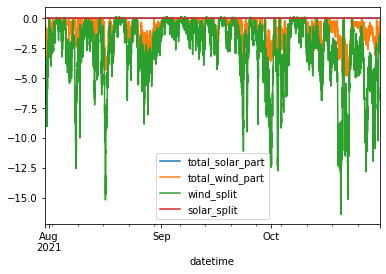

In [10]:
result.plot()

In [11]:
result.iloc[60:]

,total_solar_part,total_wind_part,wind_split,solar_split
datetime,,,,
2021-07-31 15:15:00+00:00,0,-2.09,-5.8655,1.829648e-14
2021-07-31 15:30:00+00:00,0,-1.63,-5.7800,1.829648e-14
2021-07-31 15:45:00+00:00,0,-1.54,-5.7330,1.829648e-14
2021-07-31 16:00:00+00:00,0,-1.47,-6.3905,1.829648e-14
2021-07-31 16:15:00+00:00,0,-1.43,-5.4395,1.829648e-14
...,...,...,...,...
2021-10-30 23:00:00+00:00,0,-0.43,-1.7195,1.829648e-14
2021-10-30 23:15:00+00:00,0,-0.40,-2.1145,1.829648e-14
2021-10-30 23:30:00+00:00,0,-0.44,-1.2820,1.829648e-14
